# Criando pequenos inputs

In [ ]:
import pandas as pd

df = pd.read_csv("scraper/input/hotels_24_merged.csv")

In [ ]:
df2 = pd.read_csv("scraper/input/hotels_2024.csv")
df2.shape

In [ ]:
df2[~df2.google_id.isin(df.google_id)].shape

In [ ]:
df[~df.google_id.isin(df2.google_id)]

In [ ]:
df2.iloc[0]

In [ ]:
df.shape

In [ ]:
df["sort_by"] = "newest"

In [ ]:
df[df.n_reviews_max.cumsum() < 10_000].shape

In [ ]:
cumsum = df.n_reviews_max.cumsum()
cumsum

In [ ]:
df["batch"] = -1

In [ ]:
dfs = []
step = 20_000
path = "./scraper/input/2025/"
for i in range(40):
    f = (cumsum > step*i) & (cumsum <= step*(i+1))
    df.loc[f, "batch"] = i
    dfi = df.loc[f]
    print(i, dfi.shape)
    dfs.append(dfi)
    dfi.to_csv(path+"hotels_batch_"+str(i).rjust(2,"0")+".csv", index=False)

In [ ]:
df.to_csv("./scraper/input/hotels_2025.csv", index=False)

# Normalizando e transformando índices

In [1]:
from uuid import uuid4
import faiss
import pandas as pd
import numpy as np
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
from langchain_core.globals import set_debug
import asyncio
from langchain_huggingface import HuggingFacePipeline
from transformers import pipeline
import logging
from datetime import datetime
import time
import json
from tqdm import tqdm
import os
import re

from llms.utils import timeit
from llms.models import load_model, load_embedding, query_model, query_model_async

# logging.basicConfig(level=logging.DEBUG)
# set_debug(True)

QUERY_PREFIX_E5_INSTRUCT = "Instruct: Given a Portuguese question, retrieve relevant hotel reviews that best answer the question. \nQuery: "
DOC_PREFIX = ""
QUERY_PREFIX = ""

CREATE_INDEX = True
PATH_INDEX = "data/faiss_index_gte_v5"
INDEX_BATCH_SIZE = 10_000
N_SAMPLES = None
N_RESPONSES = 5
FETCH_K = 1000
MAX_VECTOR_STORES = 1000
# PATH_DATA = "data/df_prep_2024-12-09_08-23-45_627733.pq"
PATH_DATA = "data/df_index_2025_v1.pq"
EMBEDDING_MODEL = "gte"

In [2]:
folders = os.listdir(PATH_INDEX)
f = folders[0]

In [ ]:
embeddings, _ = load_embedding("gte", task_type="retrieval_document")

In [ ]:
embeddings.embed_query("textoooooo bem quadrado bem normalizado").__len__()

In [30]:
vector_store_l2 = FAISS.load_local(
    f"{PATH_INDEX}/{f}",
    embeddings,
    allow_dangerous_deserialization=True,
)

index: faiss.Index = vector_store_l2.index
vectors = index.reconstruct_n(0, index.ntotal)

In [40]:
index_ip = faiss.IndexFlatIP(index.d)
index_ip.add(vectors)

In [41]:
vector_store_ip = FAISS(
    embedding_function=embeddings,
    index=index_ip,
    docstore=InMemoryDocstore(vector_store_l2.docstore._dict),
    index_to_docstore_id=vector_store_l2.index_to_docstore_id,
)

In [ ]:
(vector_store_ip.index.reconstruct_n(0, 1)[0] == vector_store_l2.index.reconstruct_n(0, 1)[0]).all()

In [50]:
assert vector_store_ip.index.d == vector_store_l2.index.d
assert vector_store_ip.index.ntotal == vector_store_l2.index.ntotal
assert vector_store_ip.docstore._dict == vector_store_l2.docstore._dict
assert vector_store_ip.index_to_docstore_id == vector_store_l2.index_to_docstore_id
assert (vector_store_ip.index.reconstruct_n(0, 1)[0] == vector_store_l2.index.reconstruct_n(0, 1)[0]).all()

In [ ]:
np.linalg.norm(vector_store_ip.index.reconstruct_n(0, 1)[0]) == 1

In [24]:
# get all indexes of index
vectors = index.reconstruct_n(0, index.ntotal)

In [ ]:
index_to_docstore_id = vector_store_l2.index_to_docstore_id

In [19]:
from langchain_community.vectorstores import InMemoryVectorStore
metadata = vector_store_l2.docstore._dict

In [ ]:
metadata['3b253b8c-9ecb-4a47-a29b-597057358e77'].page_content

In [ ]:
vector_store_l2.add_embeddings(vectors, )

In [ ]:
pd.Series(vectors[0]).describe()


In [ ]:
np.linalg.norm(vectors[0])

In [34]:
def normalize(vectors):
    return vectors / np.linalg.norm(vectors, axis=1, keepdims=True)
vectors_normalized = normalize(vectors)

In [ ]:
np.linalg.norm(vectors_normalized[0])

In [ ]:
pd.Series(vectors_normalized[0]).describe()

In [ ]:
def normalize(vectors):
    return vectors / np.linalg.norm(vectors, axis=1, keepdims=True)


    # NORMALIZE ALL EMBEDDINGS OF vector_store_l2
    for doc in vector_store_l2.docstore.documents:
    vector.page_content = normalize(doc.page_content)

# Sumarização

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import os
import traceback
import json

from llms.models import (
    load_model,
    query_model,
    models_text,
    models_embedding,
)
from llms.rag import load_rag, query_index, query_make_filter, load_data

In [3]:
df = load_data()

Loading data...
(222923, 22)
(222923, 22)
load_data took: 0.6429030895233154


In [4]:
from llms.summary import prep_data, make_prompt_summary_full

hotels_small, hotels_big = prep_data(df)

Text(0.5, 1.0, 'Quantidade de hotéis com mais de 1000 avaliações')

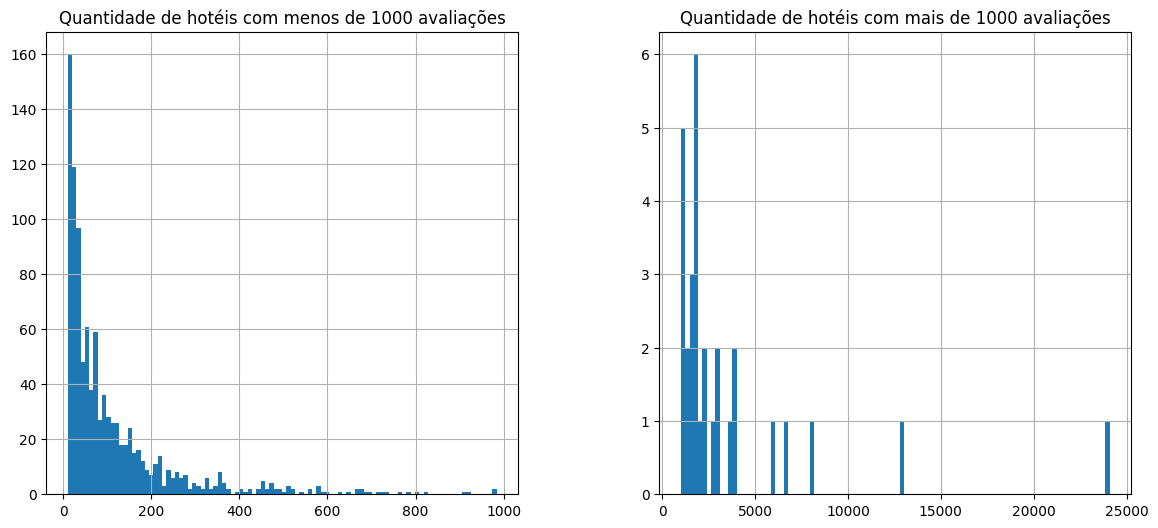

In [5]:
# Make two hist plots side by side
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

hotels_small.hist(bins=100, ax=axes[0])
hotels_big.hist(bins=100, ax=axes[1])
axes[0].set_title("Quantidade de hotéis com menos de 1000 avaliações")
axes[1].set_title("Quantidade de hotéis com mais de 1000 avaliações")

In [6]:

for hotel_name in hotels_small.nome.to_list()[-1:]:
    prompt, context = make_prompt_summary_full(hotel_name, df)


make_docs...
len(docs)=10

Você é um assistente de sumarização de hotéis em português.
Utilize os seguintes trechos de CONTEXTO recuperado de avaliações de hotéis para escrever o RESUMO.
Siga as INSTRUÇÕES do usuário para escrever um resumo detalhado do que se pede.

CONTEXTO:
Hotel: Chalés Pouso da Ilha, 0 Estrelas.
Região:NORDESTE; Estado:PERNAMBUCO; Cidade:Ilha de Itamaracá
Tipo:Hotel; Classificação:4.3; Quantidade Avaliações:145

 - Avaliação 1
Nota:5; Curtidas:0; Usuário é guia local
Avaliação: Sensacional ! Para quem aprecia uma praia bacana em um lugar super calmo e acolhedor ! Os chalés pouso da ilha é verdadeiramente tudo isso ! Ficamos hospedados esse final de semana por 3 dias e foi uma sensação sem  igual, conhecemos os proprietários Enrique e Rejane, pessoas da melhor qualidade ! Super recomendo a todos !

 - Avaliação 2
Nota:5; Curtidas:0; Usuário é guia local
Avaliação: Todas pessoas que são convidados pó min , ficam inprecionado com o local

 - Avaliação 3
Nota:5; Curti

In [14]:
llm, _, _ = load_model("gemini-2.0-flash")

load_model...
model_alias='gemini-2.0-flash' max_new_tokens=3000 model_data=('google', 'gemini-2.0-flash')
Loading ChatGoogleGenerativeAI model...
llm=ChatGoogleGenerativeAI(model='models/gemini-2.0-flash', google_api_key=SecretStr('**********'), temperature=0.0, max_output_tokens=3000, max_retries=2, timeout=10.0, client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x0000023522659790>, default_metadata=())
hf_pipe=<llms.models.GenericHuggingFacePipeline object at 0x0000023524CDC5D0>


In [15]:
from llms.models import query_model

response = query_model(llm, prompt)

query_model...
len(prompt)=3438
num_input_tokens=527
len(response)=1926
response='**Chalés Pouso da Ilha: Resumo Detalhado das Avaliações**\n\n**1. Infraestrutura e Acomodações:**\n\nOs chalés são descritos como super aconchegantes, proporcionando um ambiente tranquilo e organizado, ideal para relaxar a dois ou em família. A proximidade com o mar é um ponto forte. No entanto, uma avaliação aponta para a falta de um número de telefone funcional, indicando uma possível falta de organização e comunicação por parte do empreendimento.\n\n**2. Atendimento e Serviço:**\n\nOs proprietários, Enrique e Rejane, são elogiados pela cordialidade e atenção. Os responsáveis pelo local são considerados super atenciosos, proporcionando um atendimento de qualidade. Contudo, a dificuldade de comunicação, mencionada anteriormente, pode ser um ponto negativo no serviço prestado.\n\n**3. Localização e Acessibilidade:**\n\nA pousada está localizada em frente ao mar, em uma praia sossegada, ideal para quem bus

In [16]:
print(response)

**Chalés Pouso da Ilha: Resumo Detalhado das Avaliações**

**1. Infraestrutura e Acomodações:**

Os chalés são descritos como super aconchegantes, proporcionando um ambiente tranquilo e organizado, ideal para relaxar a dois ou em família. A proximidade com o mar é um ponto forte. No entanto, uma avaliação aponta para a falta de um número de telefone funcional, indicando uma possível falta de organização e comunicação por parte do empreendimento.

**2. Atendimento e Serviço:**

Os proprietários, Enrique e Rejane, são elogiados pela cordialidade e atenção. Os responsáveis pelo local são considerados super atenciosos, proporcionando um atendimento de qualidade. Contudo, a dificuldade de comunicação, mencionada anteriormente, pode ser um ponto negativo no serviço prestado.

**3. Localização e Acessibilidade:**

A pousada está localizada em frente ao mar, em uma praia sossegada, ideal para quem busca descanso. A Praia do Sossego é descrita como maravilhosa, mas há uma preocupação com a suje

In [17]:
from llms.g_eval import g_eval_scores

In [18]:
import pandas as pd
pd.Series([1,1,1,None]).mean()

1.0

In [19]:
result, score_final = g_eval_scores([response], context, llm, 1)

g_eval_scores...
Evaluating summary 0
metric_name='Relevância'
response='- Relevância: 5'
Sleeping 1 seconds...
metric_name='Coerência'
response='4'
Sleeping 1 seconds...
metric_name='Consistência'
response='5'
Sleeping 1 seconds...
metric_name='Fluência'
response='3'
Sleeping 1 seconds...
score_final=4.25 scores=[5, 4, 5, 3]


# Open Router

In [8]:
from llms.rag import load_rag

vector_store, rag_alias, embeddings_name = load_rag("google-ip")

load_rag...
load_embedding...
model_alias='google-4' model_name='models/text-embedding-004' task_type='retrieval_query'
Loading GoogleGenerativeAIEmbeddings model...
embeddings=GoogleGenerativeAIEmbeddings(client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x0000028D4B58CC90>, model='models/text-embedding-004', task_type='retrieval_query', google_api_key=SecretStr('**********'), credentials=None, client_options=None, transport=None, request_options=None)
rag_alias='google-ip' embedding_model_alias='google-4' embeddings_name='models/text-embedding-004' path_index='data/faiss_index_google_v4_ip'
Loading index...


  4%|▍         | 1/23 [00:00<00:13,  1.61it/s]

i=0 vector_store.index.ntotal=10000


  9%|▊         | 2/23 [00:00<00:08,  2.34it/s]

i=1 vector_store.index.ntotal=20000


 13%|█▎        | 3/23 [00:01<00:08,  2.43it/s]

i=2 vector_store.index.ntotal=30000


 17%|█▋        | 4/23 [00:01<00:07,  2.62it/s]

i=3 vector_store.index.ntotal=40000


 22%|██▏       | 5/23 [00:02<00:09,  1.98it/s]

i=4 vector_store.index.ntotal=50000


 26%|██▌       | 6/23 [00:02<00:07,  2.33it/s]

i=5 vector_store.index.ntotal=60000


 35%|███▍      | 8/23 [00:03<00:04,  3.12it/s]

i=6 vector_store.index.ntotal=70000
i=7 vector_store.index.ntotal=72923


 39%|███▉      | 9/23 [00:03<00:04,  3.28it/s]

i=8 vector_store.index.ntotal=82923


 43%|████▎     | 10/23 [00:04<00:05,  2.31it/s]

i=9 vector_store.index.ntotal=92923


 48%|████▊     | 11/23 [00:04<00:05,  2.32it/s]

i=10 vector_store.index.ntotal=102923


 52%|█████▏    | 12/23 [00:04<00:04,  2.44it/s]

i=11 vector_store.index.ntotal=112923


 57%|█████▋    | 13/23 [00:05<00:03,  2.64it/s]

i=12 vector_store.index.ntotal=122923


 61%|██████    | 14/23 [00:05<00:03,  2.83it/s]

i=13 vector_store.index.ntotal=132923


 65%|██████▌   | 15/23 [00:06<00:03,  2.04it/s]

i=14 vector_store.index.ntotal=142923


 70%|██████▉   | 16/23 [00:06<00:03,  2.04it/s]

i=15 vector_store.index.ntotal=152923


 74%|███████▍  | 17/23 [00:07<00:02,  2.33it/s]

i=16 vector_store.index.ntotal=162923


 78%|███████▊  | 18/23 [00:07<00:01,  2.56it/s]

i=17 vector_store.index.ntotal=172923


 83%|████████▎ | 19/23 [00:07<00:01,  2.60it/s]

i=18 vector_store.index.ntotal=182923


 87%|████████▋ | 20/23 [00:08<00:01,  2.77it/s]

i=19 vector_store.index.ntotal=192923


 91%|█████████▏| 21/23 [00:08<00:01,  1.98it/s]

i=20 vector_store.index.ntotal=202923


 96%|█████████▌| 22/23 [00:09<00:00,  2.26it/s]

i=21 vector_store.index.ntotal=212923


100%|██████████| 23/23 [00:09<00:00,  2.41it/s]

i=22 vector_store.index.ntotal=222923
Index loaded.
load_index took: 9.579807996749878


In [29]:
from llms.summary import make_prompts_summary_topic

prompts, contexts = make_prompts_summary_topic(
    hotel_name="Grand Palladium Imbassaí Resort & Spa",
    vector_store=vector_store,
    n_responses=100,
)

hotel_name='Grand Palladium Imbassaí Resort & Spa' i=0 topic='Infraestrutura e Acomodações – Conforto, limpeza, tecnologia, lazer, estacionamento.' positive=True
Querying index...
Query with increasing fetch_k: i=0 fetch_k=1000
len(results)=469/fetch_k=1000 n_responses=100
Results sufficient.
 - Avaliação 1, Similaridade: 0.681
Hotel: Grand Palladium Imbassaí Resort & Spa, 5 Estrelas.
Região:NORDESTE; Estado:BAHIA; Cidade:None
Tipo:None; Classificação:4.8; Quantidade Avaliações:43100
Nota:4; Curtidas:1; Usuário é guia local; Nota Quartos:5; Nota Localização:4; Nota Serviço:4
Avaliação: Foi minha primeira experiência em resorts all inclusive, pesquisei bastante e via sempre as mesmas críticas em vários locais. Acabei optando pelo Palladium após indicação de amigos. O resort realmente é bem bonito, recepção imponente, quartos espaçosos e com certo luxo. Eu e minha noiva optamos pelo pacote premium q realmente acrescenta algumas comodidades como o concierge que fica na Vila ajudando em tu

In [30]:
print(prompts[0])


Você é um assistente de sumarização de hotéis em português.
Utilize os seguintes trechos de CONTEXTO recuperado de avaliações de hotéis para escrever o RESUMO.
Siga as INSTRUÇÕES do usuário para escrever um resumo detalhado do que se pede.

CONTEXTO:
Informações sobre o hotel:Hotel: Grand Palladium Imbassaí Resort & Spa, 5 Estrelas.
Região:NORDESTE; Estado:BAHIA; Cidade:None
Tipo:None; Classificação:4.8; Quantidade Avaliações:43100

100 avaliações do hotel mais semelhantes à pergunta:
 - Avaliação 1, Similaridade: 0.681
Nota:4; Curtidas:1; Usuário é guia local; Nota Quartos:5; Nota Localização:4; Nota Serviço:4
Avaliação: Foi minha primeira experiência em resorts all inclusive, pesquisei bastante e via sempre as mesmas críticas em vários locais. Acabei optando pelo Palladium após indicação de amigos. O resort realmente é bem bonito, recepção imponente, quartos espaçosos e com certo luxo. Eu e minha noiva optamos pelo pacote premium q realmente acrescenta algumas comodidades como o con

In [23]:
from llms.models import load_model

llm, model_name, max_new_tokens = load_model("gemini-2.0-flash")

load_model...
model_alias='gemini-2.0-flash' max_new_tokens=3000 model_data=('google', 'gemini-2.0-flash')
Loading ChatGoogleGenerativeAI model...
llm=ChatGoogleGenerativeAI(model='models/gemini-2.0-flash', google_api_key=SecretStr('**********'), temperature=0.0, max_output_tokens=3000, max_retries=2, timeout=10.0, client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x0000028D970B4190>, default_metadata=())
hf_pipe=<llms.models.GenericHuggingFacePipeline object at 0x0000028D97650850>


In [31]:
from llms.summary import make_prompt_summary_full_v2

prompt, context = make_prompt_summary_full_v2(
    hotel_name="Grand Palladium Imbassaí Resort & Spa",
    vector_store=vector_store,
    n_responses=100,
)

Querying index...
Query with increasing fetch_k: i=0 fetch_k=1000
len(results)=512/fetch_k=1000 n_responses=100
Results sufficient.
 - Avaliação 1, Similaridade: 0.696
Hotel: Grand Palladium Imbassaí Resort & Spa, 5 Estrelas.
Região:NORDESTE; Estado:BAHIA; Cidade:None
Tipo:None; Classificação:4.8; Quantidade Avaliações:43100
Nota:2; Curtidas:4; Usuário é guia local
Avaliação: Estive neste resort recentemente. Infelizmente tem alguns pontos negativos: percebemos que muitos funcionários não estavam treinados e a falta de gerentes por setor no resort era quase nula. No restaurante era possível notar a falta de experiência maís o pior mesmo era a falta de responsáveis no local, na área da piscina, no bar molhado se vc tiver a sorte de ser atendida por alguns dos bons funcionários, tudo bem. Mas nem todos os dias são assim, infelizmente o mau humor de alguns que demoram pra atender e ficam testando a nossa paciência. No chek in, horrível . Falta clareza na hora de escolher os quartos, por e

In [33]:
print(prompt)


Você é um assistente de sumarização de hotéis em português.
Utilize os seguintes trechos de CONTEXTO recuperado de avaliações de hotéis para escrever o RESUMO.
Siga as INSTRUÇÕES do usuário para escrever um resumo detalhado do que se pede.

CONTEXTO:
Informações gerais sobre o hotel:Hotel: Grand Palladium Imbassaí Resort & Spa, 5 Estrelas.
Região:NORDESTE; Estado:BAHIA; Cidade:None
Tipo:None; Classificação:4.8; Quantidade Avaliações:43100

Top 100 avaliações do hotel mais semelhantes à pergunta:
 - Avaliação 1, Similaridade: 0.696
Nota:2; Curtidas:4; Usuário é guia local
Avaliação: Estive neste resort recentemente. Infelizmente tem alguns pontos negativos: percebemos que muitos funcionários não estavam treinados e a falta de gerentes por setor no resort era quase nula. No restaurante era possível notar a falta de experiência maís o pior mesmo era a falta de responsáveis no local, na área da piscina, no bar molhado se vc tiver a sorte de ser atendida por alguns dos bons funcionários, t

In [34]:
from llms.models import query_model

summary = query_model(llm, prompt)

query_model...
len(prompt)=120416
num_input_tokens=19392
len(response)=3584
response='Aqui está um resumo do Grand Palladium Imbassaí Resort & Spa, com base nas avaliações fornecidas, abordando os tópicos solicitados:\n\n**1. Infraestrutura e Acomodações:**\n\nO Grand Palladium Imbassaí oferece uma estrutura geralmente considerada boa, com quartos espaçosos e confortáveis, equipados com banheira e varanda. No entanto, alguns hóspedes relataram problemas com a manutenção, como TVs que ligam sozinhas, ventiladores barulhentos e banheiras que não funcionam. A limpeza também foi um ponto de reclamação para alguns, com relatos de quartos sujos no check-in e falta de reposição de itens como toalhas e frigobar. Embora a estrutura seja visualmente atraente, alguns detalhes como a falta de tomadas USB e paredes com isolamento acústico deficiente foram mencionados como pontos negativos.\n\n**2. Atendimento e Serviço:**\n\nO atendimento é um ponto misto. Muitos hóspedes elogiaram a cordialidade e

In [35]:
print(summary)

Aqui está um resumo do Grand Palladium Imbassaí Resort & Spa, com base nas avaliações fornecidas, abordando os tópicos solicitados:

**1. Infraestrutura e Acomodações:**

O Grand Palladium Imbassaí oferece uma estrutura geralmente considerada boa, com quartos espaçosos e confortáveis, equipados com banheira e varanda. No entanto, alguns hóspedes relataram problemas com a manutenção, como TVs que ligam sozinhas, ventiladores barulhentos e banheiras que não funcionam. A limpeza também foi um ponto de reclamação para alguns, com relatos de quartos sujos no check-in e falta de reposição de itens como toalhas e frigobar. Embora a estrutura seja visualmente atraente, alguns detalhes como a falta de tomadas USB e paredes com isolamento acústico deficiente foram mencionados como pontos negativos.

**2. Atendimento e Serviço:**

O atendimento é um ponto misto. Muitos hóspedes elogiaram a cordialidade e educação da maioria dos funcionários, com destaque para alguns nomes como Parizia, Alexandre 

In [28]:
print(summary)

Com base nas avaliações dos hóspedes do Grand Palladium Imbassaí Resort & Spa, os aspectos negativos relacionados à infraestrutura e acomodações incluem:

*   **Manutenção e Limpeza:** Muitos hóspedes relataram problemas de manutenção nos quartos, como ar condicionado quebrado ou com vazamentos, frigobar que não funciona ou vaza água, banheiras encardidas ou com hidromassagem inoperante, ventiladores de teto barulhentos ou mal fixados, e falta de reparos em equipamentos danificados. A limpeza dos quartos também foi criticada, com relatos de sujeira, mofo, cheiro de umidade, falta de reposição de itens como toalhas e produtos de higiene, e até mesmo a presença de baratas.
*   **Infraestrutura:** Alguns quartos ficam distantes da piscina e em andares superiores sem elevador, o que dificulta o acesso para pessoas com mobilidade reduzida ou famílias com crianças. A estrutura da praia é considerada distante e com pouca estrutura de apoio.
*   **Conforto:** Alguns hóspedes reclamaram de trav

In [12]:
from llms.rag import query_index

docs, context = query_index(
    vector_store=vector_store,
    query="Qual hotel tem o melhor café?",
    filter={"nome": {"$eq": "Ancona Center Hotel"}, "nota_avaliacao": {"$gte": 3}},
    n_responses=10,
)
context

Querying index...
Query with increasing fetch_k: i=0 fetch_k=1000
len(results)=6/fetch_k=1000 n_responses=10
Query with increasing fetch_k: i=1 fetch_k=10000
len(results)=35/fetch_k=10000 n_responses=10
Results sufficient.
 - Avaliação 1, Similaridade: 0.686
Hotel: Ancona Center Hotel, 3 Estrelas.
Região:SUDESTE; Estado:SÃO PAULO; Cidade:Amparo
Tipo:Hotel; Classificação:4.2; Quantidade Avaliações:717
Nota:3; Curtidas:0; Usuário é guia local; Nota Quartos:3; Nota Localização:5; Nota Serviço:4
Avaliação: Bom hotel, bem localizado, acho que precisa renovar os baheiros, apenas. Café da manhã completo, muito bem servido. Atendimento simpático.


 - Avaliação 2, Similaridade: 0.687
Hotel: Ancona Center Hotel, 3 Estrelas.
Região:SUDESTE; Estado:SÃO PAULO; Cidade:Amparo
Tipo:Hotel; Classificação:4.2; Quantidade Avaliações:717
Nota:5; Curtidas:1; Usuário é guia local
Avaliação: Atendimento  maravilhoso, limpeza,café da manhã  diversificado e  muito  gostoso. Recomendo.


 - Avaliação 3, Similar

' - Avaliação 1, Similaridade: 0.686\nHotel: Ancona Center Hotel, 3 Estrelas.\nRegião:SUDESTE; Estado:SÃO PAULO; Cidade:Amparo\nTipo:Hotel; Classificação:4.2; Quantidade Avaliações:717\nNota:3; Curtidas:0; Usuário é guia local; Nota Quartos:3; Nota Localização:5; Nota Serviço:4\nAvaliação: Bom hotel, bem localizado, acho que precisa renovar os baheiros, apenas. Café da manhã completo, muito bem servido. Atendimento simpático.\n\n - Avaliação 2, Similaridade: 0.687\nHotel: Ancona Center Hotel, 3 Estrelas.\nRegião:SUDESTE; Estado:SÃO PAULO; Cidade:Amparo\nTipo:Hotel; Classificação:4.2; Quantidade Avaliações:717\nNota:5; Curtidas:1; Usuário é guia local\nAvaliação: Atendimento  maravilhoso, limpeza,café da manhã  diversificado e  muito  gostoso. Recomendo.\n\n - Avaliação 3, Similaridade: 0.687\nHotel: Ancona Center Hotel, 3 Estrelas.\nRegião:SUDESTE; Estado:SÃO PAULO; Cidade:Amparo\nTipo:Hotel; Classificação:4.2; Quantidade Avaliações:717\nNota:3; Curtidas:0; Usuário é guia local\nAvalia

In [ ]:
from llms.models import load_model

llm, model_name, max_new_tokens = load_model("gemini-2.0-flash")

In [22]:
# Test all models
# for a in models_text:
#     if models_text[a][0] in ["local","google"]:
#         continue
#     print(a)
#     llm, model_name, max_new_tokens = load_model(a)
#     llmresult = llm.generate(["hi"])
#     print(llmresult)
#     response = llmresult.generations[0][0].text
#     print(response)